In [1]:
from os.path import join as path_join
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from os.path import isfile
import pandas as pd
import numpy as np
import matplotlib
import requests
import operator
import json
import sys
import os

pd.options.display.float_format = '{:.4g}'.format

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

py.init_notebook_mode(connected=True)

In [2]:
CITY = "spb"

In [3]:
def load_json(fn):
    with open(fn, "r") as f:
        return json.load(f)

nb_settings = load_json("notebooks_settings.json")  
city_center = nb_settings[CITY]['city_center']
opposite_city = nb_settings[CITY]['opposite_city']

In [4]:
project_path = "/Users/pavel/Sources/python/concepts/insta/"

scenes_path_template = "cv_sandbox/photo_tagger/scenes_{}.json"
scenes_path = scenes_path_template.format(CITY)
scenes_opposite_path = scenes_path_template.format(opposite_city)

photos_path_template = "photos_{}/"
photos_path = photos_path_template.format(CITY)
photos_opposite_path = photos_path_template.format(opposite_city)

adresses_path = "scripts/adresses_{}.csv".format(CITY)

wiki_path = "wiki/"
osm_path = "osm/"

MAPBOX_TOKEN = "pk.eyJ1IjoicHNrcnl1Y2hrb3YiLCJhIjoiY2pvNWtwaWIzMGF1ejNxcGJ3M2Fob2plZyJ9.-xTZXfr4wEZMm3wfkucJlw"

In [5]:
fn1 = path_join(project_path, scenes_path.format(CITY))
data1 = load_json(fn1)

In [6]:
path = path_join(project_path, photos_path)
loc_file = list(map(lambda x: x.strip().split(","), open(path_join(path, "loc_info.csv"), "r").readlines()[1:]))
id2loc = {x[0]: x[1] for x in loc_file}

In [7]:
def relevant_places(tag, n_top=100):
    d = {}
    for loc in list(data1.keys()):
        loc_val = 0
        for photo in data1[loc]:
            val = 0
            if tag in data1[loc][photo]['categories']:
                val = data1[loc][photo]['categories'][tag]
            loc_val += float(val)
        if loc_val > 0:
            d[loc] = loc_val
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)[:n_top]

### Areas & Streets

In [8]:
def area_normalize(s):
    stopword = "район"
    return s.replace(stopword, "").strip()


def street_normalize(s):
    return s.title()


# FIXME: multiple headers in adresses_city
AREA_COLUMN = 'state_district'
STREET_COLUMN = 'road'

geo_table = pd.read_csv(path_join(project_path, adresses_path), 
                        error_bad_lines=False)
geo_table[AREA_COLUMN] = list(map(area_normalize, 
                                  geo_table[AREA_COLUMN].tolist()))
geo_table[STREET_COLUMN] = list(map(street_normalize, 
                                    geo_table[STREET_COLUMN].tolist()))

streets = geo_table[STREET_COLUMN].tolist()
areas = geo_table[AREA_COLUMN].tolist()

street_locations_n = sorted(Counter(streets).items(), 
                             key=operator.itemgetter(1), reverse=True)

area_locations_n = sorted(Counter(areas).items(), 
                           key=operator.itemgetter(1), reverse=True)
###

TOP_AREAS_N = 10
TOP_STREETS_N = 100
TOP_STREETS_VIS = 15

areas = [x[0] for x in area_locations_n[1:TOP_AREAS_N+1]] 
area_activity = [x[1] for x in area_locations_n[1:TOP_AREAS_N+1]]

streets = [x[0] for x in street_locations_n[1:TOP_STREETS_N+1]]
street_activity = [x[1] for x in street_locations_n[1:TOP_STREETS_N+1]]

In [9]:
def street_area_combine_plot(streets_barchart_y, 
                             streets_barchart_x,
                             areas_barchart_values, 
                             areas_piechart_labels):    
    HOLE = 0.5
    PULL = 0.05
    PIE_AREA_X = [0.1, 1.0]
    PIE_AREA_Y = [0.15, 0.85]
    BAR_CHART_OPACITY = 0.8
    BAR_CHART_COLOR = 'red'
    BAR_CHART_CM = "Wistia"
    BAR_CHART_LEGEND_X = 0.55
    BAR_CHART_LEGEND_Y = 0.0
    
    FONT_SIZE = 11
    TICK_LEN = 4
    PLOT_HEIGHT = 320
    PLOT_WIDTH = 900
    BAR_CHART_AREA_X = [0, 0.25]
    BAR_CHART_AREA_Y = [0, 1.0]
    MARGIN = go.layout.Margin(l=220, t=30, b=30, r=0)
    
    colormap = matplotlib.cm.get_cmap(BAR_CHART_CM)
    norm_val = np.linspace(1.0, 0.2, N_TOP_AREAS + 1)
    pieces_colors = list(map(lambda x: 
                             matplotlib.colors.rgb2hex(colormap(x)), 
                             norm_val))
    
    data = [go.Bar(y=streets_barchart_y,
                    x=streets_barchart_x,
                    marker=dict(color='red'), 
                    orientation='h', 
                    opacity=BAR_CHART_OPACITY, 
                    showlegend=False),

            go.Pie(values=areas_barchart_values,
                    labels=areas_piechart_labels,
                    domain=dict(x=PIE_AREA_X, y=PIE_AREA_Y),
                    hoverinfo="label+percent+value",
                    textinfo='label+value', 
                    textposition='outside',
                    hole=HOLE,
                    sort=False,
                    marker=dict(colors=pieces_colors), 
                    pull=PULL)]
    
    layout = go.Layout(height=PLOT_HEIGHT, width=PLOT_WIDTH,
                       showlegend=False, 
                       margin=MARGIN, 
                       xaxis=dict(domain=BAR_CHART_AREA_X),
                       font=dict(size=FONT_SIZE, color='grey'),
                       yaxis=dict(domain=BAR_CHART_AREA_Y, 
                                  autorange="reversed", 
                                  ticklen=TICK_LEN))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, show_link=False)

    
N_TOP_AREAS = 5
OTHER_LABEL = "другое"
street_area_combine_plot(streets[:TOP_STREETS_VIS],
                         street_activity[:TOP_STREETS_VIS],
                         area_activity[:N_TOP_AREAS]+ 
                             [sum(area_activity[N_TOP_AREAS+1:])],
                         areas[:N_TOP_AREAS]+[OTHER_LABEL])

In [10]:
def download_streets_coordinates(streets):
    request_template = "https://nominatim.openstreetmap.org/search.php?q={}&format=xml"
    street_coordinates = {}
    for x in streets:
        query = (x + " " + CITY).replace(" ", "+")
        request = requests.get(request_template.format(query))
        soup = BeautifulSoup(request.text, "lxml")
        place_tag = soup.find('place')
        try:
            street_coordinates[x] = [place_tag['lat'], place_tag['lon']]
        except:
            print("Error", x)
    return street_coordinates

def get_streets_coordinates(streets):
    street_coordinates_fn = path_join(osm_path, 'street_coordinates_{}.json'.format(CITY))
    if isfile(street_coordinates_fn):
        with open(street_coordinates_fn, 'r') as f:
            street_coordinates = json.load(f)    
    else:
        street_coordinates = download_streets_coordinates(streets)
        with open(street_coordinates_fn, 'w') as outfile:
            json.dump(street_coordinates, outfile)
            
    return street_coordinates

street_coordinates = get_streets_coordinates(streets)

In [11]:
def city_map(scatter_lat, scatter_lon, scatter_hover):
    MARKER_SIZE = 17
    MARKER_OPACITY = 0.4
    MARKER_COLOR = 'red'
    ZOOM = 12
    MARGIN = dict(l=0, r=30, b=0, t=20)
    MAP_WIDTH = 700
    MAP_HEIGHT = 400
    MAX_MARKER_SIZE = 35

    marker_sizes = [x if x < MAX_MARKER_SIZE else MAX_MARKER_SIZE 
                    for x in street_activity]

    data = [go.Scattermapbox(
                lat=lat,
                lon=lon,
                mode='markers',
                marker=dict(
                    size=marker_sizes,
                    color=MARKER_COLOR,
                    opacity=MARKER_OPACITY),
                text=streets,
                hoverinfo='text')]

    layout = go.Layout(
                width=MAP_WIDTH,
                height=MAP_HEIGHT,
                hovermode='closest',
                margin=MARGIN,
                mapbox=dict(
                    accesstoken=MAPBOX_TOKEN,
                    center=dict(
                        lat=city_center[0],
                        lon=city_center[1]),
                    zoom=ZOOM,
                    style='light'))

    fig = dict(data=data, layout=layout)
    py.iplot(fig, show_link=False)
 

lat = [x[0] for x in street_coordinates.values()]
lon = [x[1] for x in street_coordinates.values()]

city_map(lat, lon, streets)

In [12]:
wiki_locations_df = pd.read_csv(path_join(wiki_path, 
                                "wiki_located_items_{}.csv".format(CITY)))

wiki_locations_df.views = wiki_locations_df.views.astype(int)
wiki_locations_df.lon = wiki_locations_df.lon.astype(float)
wiki_locations_df.lat = wiki_locations_df.lat.astype(float)

# remove city from locations list
#wiki_locations_df = wiki_locations_df.drop([0])

wiki_locations_df = wiki_locations_df.sort_values(by='views', 
                                                  ascending=False)
wiki_locations_df = wiki_locations_df[wiki_locations_df['wiki_name']. \
                                      map(lambda x: x.lower())!='berlin']

wiki_locations_df['street'] = wiki_locations_df['roads']

wiki_locations_df = wiki_locations_df.drop(columns=['suburb', 'roads'])

wiki_locations_df = wiki_locations_df[wiki_locations_df['street'] != '']

wiki_locations_df['street'] = wiki_locations_df['street'].astype(str)

wiki_locations_df['street'] = list(map(lambda x: x.title(), 
                                       wiki_locations_df['street']))
###

stopwords = ['nazi']

for word in stopwords:
    wiki_locations_df = wiki_locations_df[wiki_locations_df['wiki_name'] \
                        .map(lambda x: not word in x.lower().split())]

###
    
streets_longlist = [x[0] for x in street_locations_n]
street_activity_longlist = [x[1] for x in street_locations_n]
street_coordinates = get_streets_coordinates(streets_longlist)

###

street_wiki_df = wiki_locations_df[['views', 'street']]

street_wiki_df = street_wiki_df.groupby(['street'])\
                               .sum()\
                               .sort_values(by=['views'], ascending=False)\
                               .reset_index()
###

street_activity_dict = {x: y for x, y in zip(streets_longlist, 
                                             street_activity_longlist)}

street_wiki_dict = {x: y for x, y in zip(street_wiki_df['street'], 
                                         street_wiki_df['views'])}

###

top_df = pd.read_csv(path_join(project_path, 
                     "scripts/top_places_{}.txt".format(CITY)), 
                     header=None)
top_df.columns = ['name', 'area', 'link', 'photos_counter']

loc_id = []
for x in top_df.link:
    loc_id.append(x.split("/")[3])

top_df['id'] = loc_id

top_df = top_df.drop([0])

###

top_df.id = top_df.id.astype(int)
geo_table.id = geo_table.id.astype(int)
photos_top_streets = pd.merge(top_df, geo_table, on='id') \
                                [['road', 'photos_counter']]

photos_top_streets = photos_top_streets.groupby(['road'])\
                               .sum()\
                               .sort_values(by=['photos_counter'], ascending=False)\
                               .reset_index()

photos_top_streets = photos_top_streets[photos_top_streets['road'] != 'None']
photos_top_streets['photos_counter'] = \
                    photos_top_streets['photos_counter'].astype(int)

###

grouped = wiki_locations_df[['street', 'wiki_name', 'views']].groupby('street')

street_locs_wiki = {}
max_locs = 5
for street,group in grouped:
    locs = list(zip(group.wiki_name.tolist(), group.views.tolist()))
    street_locs_wiki[street] = locs[:max_locs]

###

grouped = pd.merge(top_df, geo_table, on='id') \
                [['road', 'location', 'photos_counter']].groupby('road')

street_locs = {}
max_locs = 5
for street,group in grouped:
    locs = list(zip(group.location.tolist(), 
                    group.photos_counter.tolist()))
    
    street_locs[street] = locs[:max_locs]
    
###

def tuple_to_str(t):
    return('{}, {}'.format(trim(t[0].replace("_", " ").strip()), t[1]))


def trim(s, max_len=20):
    if len(s) <= max_len:
        return s
    else:
        s = s[:max_len].strip("_")
        return s + "..."
   

street_insta_dict = {x: y for x, y in zip(photos_top_streets['road'].tolist(), 
                                          photos_top_streets['photos_counter'] \
                                          .tolist())}
ignore_zeros = True
labels_wiki, short_labels = [], []
xc, yc = [], []
for z in street_insta_dict:
    if z in street_wiki_dict:
        xc.append(street_insta_dict[z])
        yc.append(street_wiki_dict[z])
    
        short_labels.append(z)
        labels_wiki.append('<i>{}</i><br>{}'.format(z, 
                            "<br>".join(map(tuple_to_str, 
                                            street_locs_wiki[z]))))
    else:
        if ignore_zeros:
            continue
        else:
            xc.append(street_insta_dict[z])
            yc.append(1)
            short_labels.append(z)
            labels_wiki.append('<i>{}</i><br>{}'.format(z, 
                                "<br>".join(map(tuple_to_str, 
                                                street_locs_wiki[z]))))      

In [13]:
def insta_wiki_scatter(scatter_x, scatter_y, scatter_labels):
    PLOT_HEIGHT = 350
    PLOT_WIDTH = 450
    
    trace = go.Scatter(x=scatter_x, y=scatter_y,
                       text=scatter_labels,
                       mode = 'markers',
                       hoverinfo='text',
                       marker=dict(color='dodgerblue',
                                   opacity=0.8))

    shapes=[dict(type='line',
                 xref='x', yref='paper',
                 x0=np.median(scatter_x), y0=0,
                 x1=np.median(scatter_x), y1=1,
                 line=dict(color='grey', width=1)),
            dict(type='line',
                 xref='paper',yref='y',
                 x0=0, y0=np.median(scatter_y),
                 x1=1, y1=np.median(scatter_y),
                 line=dict(color='grey', width=1))]

    layout = go.Layout(width=PLOT_WIDTH,
                       height=PLOT_HEIGHT,
                       margin = go.layout.Margin(t=30, b=50, l=50, r=30),
                       xaxis=dict(
                            title='insta', type='log'),
                       yaxis=dict(
                            title='wiki', type='log'),
                       hovermode='closest',
                       shapes=shapes)

    fig = go.Figure(data=[trace], layout=layout)
    py.iplot(fig, show_link=False)
    
    
insta_wiki_scatter(xc, yc, labels_wiki)

In [14]:
N_SCENES = 25
SELECTED_TAGS = ['library/indoor', 'restaurant', 'street', 'bar', 
                 'discotheque', 'promenade', 'museum/indoor', 'art_gallery', 
                 'bridge', 'dressing_room', 'picnic_area', 'beer_hall', 
                 'skyscraper', 'bookstore', 'closet', 'television_studio', 
                 'stadium/soccer', 'pub/indoor', 'industrial_area', 'art_studio',
                 'lawn', 'highway', 'coffee_shop', 'booth/indoor', 'martial_arts_gym']

def get_tags(mode, top_scenes=None):
    if mode == "top":
        return [x[0] for x in top_scenes]
    elif mode == "selected":
        return SELECTED_TAGS

In [15]:
def calculate_street_enviroment():
    locations_env = []
    for loc in list(data1.keys()):
        photo_env = []
        for photo in data1[loc]:
            photo_env.append(data1[loc][photo]['enviroment'])
            
        env_counter = dict(Counter(photo_env))
        
        street = geo_table[geo_table['id'] == int(loc)] \
                                    [STREET_COLUMN].tolist()
        
        if 'outdoor' in env_counter:
            outdoor_cn = env_counter['outdoor']
        else:
            outdoor_cn = 0
            
        if 'indoor' in env_counter:
            indoor_cn = env_counter['indoor']
        else:
            indoor_cn = 0
        
        if street and street[0] != 'None':
            locations_env.append([loc, outdoor_cn, 
                                  indoor_cn, 
                                  street[0]])
    locations_env = pd.DataFrame(locations_env)
    locations_env.columns = ['id', 'outdoor', 'indoor', 'street']
    return locations_env


def build_tags_table(tags, scene_data):
    dd = []
    for loc in list(scene_data.keys()):
        cn = Counter()
        location_data = scene_data[loc]
        for photo in location_data:
            photo_data = scene_data[loc][photo]['categories'].items()
            for category, val in photo_data:
                cn[category] += float(val) / len(location_data)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table

In [16]:
locations_env = calculate_street_enviroment()

env_data = {}
for street in locations_env['street'].unique():
    outdoor_cn = locations_env[locations_env['street'] == street] \
                                                        ['outdoor'].sum()
    indoor_cn = locations_env[locations_env['street'] == street] \
                                                        ['indoor'].sum()
    env_data[street] = [outdoor_cn, indoor_cn]
    
####

street_outdoor_data, street_indoor_data = [], []
for x in streets:
    if x in env_data:
        street_outdoor_data.append(env_data[x][0])
        street_indoor_data.append(env_data[x][1])
    
####

street_outdoor_data = np.array(street_outdoor_data)
street_indoor_data = np.array(street_indoor_data)

outdoor_rate = street_outdoor_data / \
                    (street_indoor_data + street_outdoor_data)

####

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
            
all_tags = list(cn.keys())
forbidden_tags = ["beauty_salon", "dressing_room"]
for x in forbidden_tags:
    all_tags.remove(x)

####

selected_tags = get_tags('selected')

opposite_scenes = load_json(path_join(project_path, 
                                      scenes_path))
target_scenes = load_json(path_join(project_path, 
                                    scenes_opposite_path))

opposite_tags_table = build_tags_table(all_tags, 
                                       opposite_scenes)
target_tags_table = build_tags_table(all_tags, 
                                     target_scenes)

general_tags_table = np.vstack((target_tags_table[all_tags] \
                                .values.tolist(), 
                                opposite_tags_table[all_tags] \
                                .values.tolist()))

target_scenes = load_json(path_join(project_path, scenes_path))
target_tags_table = build_tags_table(all_tags, target_scenes)

####

night_tags = ['bar', 'discotheque', 'beer_hall', 
              'pub/indoor', 'restaurant']

day_tags = [x for x in SELECTED_TAGS if not x in night_tags and \
                                        not x in forbidden_tags]
####

daily_activity_list = []
for loc in list(data1.keys()):
    row = target_tags_table[target_tags_table['id'] == loc]
    day_val = row[day_tags].values.sum()
    night_val = row[night_tags].values.sum()
    if loc in id2loc:
        street = geo_table[geo_table['id'] == int(loc)]\
                                            [STREET_COLUMN].tolist()
        if street and street[0] != 'None':
            daily_activity_list.append([loc, day_val, 
                                        night_val, street[0]])
        
daily_activity_table = pd.DataFrame(daily_activity_list)
daily_activity_table.columns = ['id', 'day', 'night', 'street']

####

daily_activity_dict = {}
for street in locations_env['street'].unique():
    day_cn = daily_activity_table[daily_activity_table['street'] == street]\
                                                        ['day'].values.sum()
    night_cn = daily_activity_table[daily_activity_table['street'] == street]\
                                                        ['night'].values.sum()
    
    daily_activity_dict[street] = [day_cn, night_cn]
    
####

street_day_activity, street_night_activity = [], []
for x in streets:
    if x in daily_activity_dict:
        street_day_activity.append(daily_activity_dict[x][0])
        street_night_activity.append(daily_activity_dict[x][1])
        
####

street_ticks = np.array(streets)

street_day_activity = np.array(street_day_activity)
street_night_activity = np.array(street_night_activity)

day_activity_rate = np.array(street_day_activity / 
                             (street_day_activity + 
                              street_night_activity))

In [17]:
def env_time_combine_plot(env_bar_y, day_bar_y, lables):
    VERTICAL_SPACING = 0.09
    INDOOR_OPACITY = 0.5
    NIGHT_OPACITY = 0.5
    FONTSIZE = 11
    PLOT_HEIGHT = 350
    PLOT_WIDTH = 760
    LEGEND_X = 1.01
    LEGEND_Y = 0.5
    ENV_COLOR = 'red'
    DAILY_COLOR = 'dodgerblue'
    FONTCOLOR = 'lightgrey'
    MARGIN = go.layout.Margin(t=30, b=150, l=20)
    
    fig = tools.make_subplots(rows=2, cols=1,
                              vertical_spacing=VERTICAL_SPACING,
                              print_grid=False)
    outdoor_trace = go.Bar(
        y=env_bar_y,
        x=lables,
        marker=dict(color=ENV_COLOR), 
        name="outdoor rate",
        legendgroup='group1')

    indoor_trace = go.Bar(
        y=1-env_bar_y,
        x=lables,
        marker=dict(color=ENV_COLOR), 
        opacity=INDOOR_OPACITY,
        name="indoor rate",
        legendgroup='group1')

    fig.append_trace(outdoor_trace, 1, 1)
    fig.append_trace(indoor_trace, 1, 1)

    day_trace = go.Bar(y=day_bar_y,
                       x=lables,
                       marker=dict(color=DAILY_COLOR), 
                       name="day rate",
                       legendgroup='group2')

    night_trace = go.Bar(y=1-day_bar_y,
                         x=lables,
                         marker=dict(color=DAILY_COLOR), 
                         opacity=NIGHT_OPACITY,
                         name="night rate",
                         legendgroup='group2')

    fig.append_trace(day_trace, 2, 1)
    fig.append_trace(night_trace, 2, 1)

    fig['layout'].update(width=PLOT_WIDTH, height=PLOT_HEIGHT,
                         legend=dict(x=LEGEND_X, y=LEGEND_Y), 
                         barmode='stack', margin=MARGIN,
                         xaxis1=dict(showticklabels=False),
                         xaxis2=dict(tickangle=-90, 
                                     tickfont=dict(size=FONTSIZE, color=FONTCOLOR)))

    py.iplot(fig, show_link=False)

    
ENV_TIME_N_TICKS = 40
env_time_combine_plot(outdoor_rate[:ENV_TIME_N_TICKS], 
                      day_activity_rate[:ENV_TIME_N_TICKS], 
                      street_ticks[:ENV_TIME_N_TICKS])

### Tags

In [18]:
cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)

top_scenes = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)[:N_SCENES]

tags = get_tags('selected', top_scenes)
scenes_result = sorted([[x, cn[x]] for x in tags], key=lambda x: x[1], reverse=True)

N_SKIP = 0
MAX_HOVER_LEN = 25

top_places = [relevant_places(key, 5) for key, _ in scenes_result][N_SKIP:]
id_list_to_name = lambda x: [trim(id2loc[y[0]], MAX_HOVER_LEN) for y in x]


In [19]:
fn3 = path_join(project_path, scenes_opposite_path)

with open(fn3, "r") as f:
    data3 = json.load(f)

cn = Counter()
for loc in list(data3.keys()):
    for photo in data3[loc]:
        for category, val in data3[loc][photo]['categories'].items():
            cn[category] += float(val)

scenes_result2 = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)

d1 = {x[0]: x[1]/len(data1) for x in scenes_result}
d2 = {x[0]: x[1]/len(data3) for x in scenes_result2}

sc_delta_val = []
for x in d1:
    if x in d1 and x in d2:
        sc_delta_val.append([x, d1[x]-d2[x]])
    else:
        print("error", x, x in d1, x in d2)

sc_tags = [z[0] for z in sorted(scenes_result, key=lambda x: x[0])]

sc_delta = sorted(sc_delta_val, key=lambda x: abs(x[1]), reverse=True)[:25]
sc_delta = sorted(sc_delta, key=lambda x: x[1], reverse=False)

In [22]:
def tags_rate_delta_combine(bar_x, bar_y, delta_bar_x, delta_bar_y):
    FONT_SIZE = 11
    PLOT_WIDTH = 770
    PLOT_HEIGHT = 330
    VERTICAL_SPACING = 0.15
    RATE_BAR_COLOR = 'deeppink'
    DELTA_BAR_COLOR = 'mediumseagreen'
    TICKFONT_COLOR = 'lightgrey'
    MARGIN = go.layout.Margin(t=30, b=120, l=30, r=25)
    
    fig = tools.make_subplots(rows=1, cols=2, print_grid=False, 
                              horizontal_spacing=0.08,
                              vertical_spacing=VERTICAL_SPACING)

    fig.append_trace(go.Bar(x=bar_x,
                            y=bar_y,
                            marker=dict(color=RATE_BAR_COLOR),
                            text=[" <br>".join(id_list_to_name(x)) 
                                                  for x in top_places],
                            hoverinfo="y+text"), 1,1)

    fig.append_trace(go.Bar(x=delta_bar_x,
                            y=delta_bar_y,
                            marker = dict(color=DELTA_BAR_COLOR)),1,2)

    yaxis_style = dict(tickfont=dict(size=FONT_SIZE, color=TICKFONT_COLOR))
    xaxis_style = dict(tickfont=dict(size=FONT_SIZE, color=TICKFONT_COLOR), 
                       tickangle=-90)
    
    fig['layout'].update(height=PLOT_HEIGHT, width=PLOT_WIDTH,
                         yaxis1=yaxis_style, yaxis2=yaxis_style,
                         xaxis1=xaxis_style, xaxis2=xaxis_style,
                         margin=MARGIN, showlegend=False)

    py.iplot(fig, show_link=False)

    
tags_rate_delta_combine([x[0].split("/")[0] for x in scenes_result][N_SKIP:],
                        [x[1] for x in scenes_result][N_SKIP:],
                        [x[0] for x in sc_delta],
                        [x[1] for x in sc_delta])

In [21]:
sorted_tags = [x[0] for x in scenes_result]

def build_tags_table():
    dd = []
    for loc in list(data1.keys()):
        cn = Counter()
        for photo in data1[loc]:
            for category, val in data1[loc][photo]['categories'].items():
                cn[category] += float(val)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


def calculate_street_vectors():
    keywords_table = build_tags_table()
    street_vectors = []
    for s in streets[:TOP_STREETS_VIS]:
        sv = np.zeros(N_SCENES)
        locations_id = geo_table[geo_table[STREET_COLUMN]==s]['id'].astype(str)
        for loc in locations_id:
            if loc in keywords_table.id.values:
                is_relevant = keywords_table['id']==loc
                relevant_row = keywords_table[is_relevant][sorted_tags]
                location_vector = relevant_row.iloc[0].tolist()
                sv += location_vector

        street_vectors.append(sv)
    
    return np.array(street_vectors)

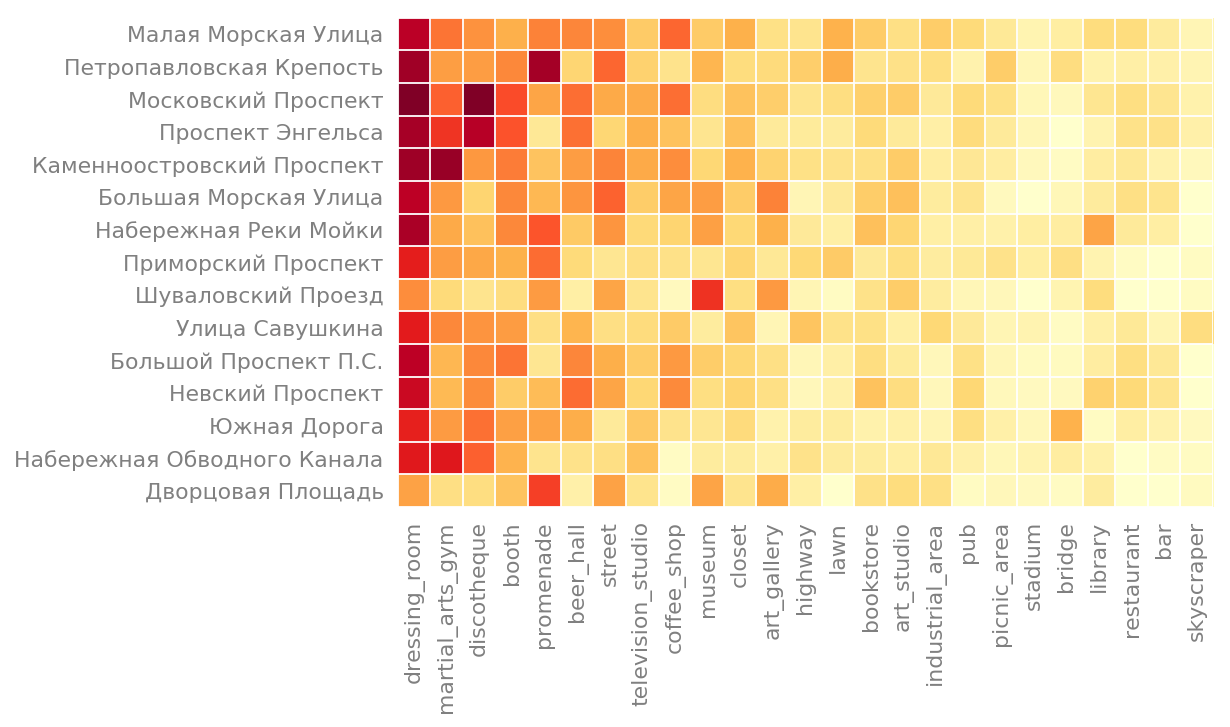

In [32]:
def streets_features_plot(features_matrix, street_labels, tag_labels):
    FONT_SIZE = 11
    MAX_IM_VALUE = 7
    GRID_WIDTH = 0.9
    PLT_WIDTH = 8.5
    PLT_HEIGHT = 4.5
    PLOT_FACTOR = 0.5
    COLORMAP = 'YlOrRd'
    LABEL_COLOR = 'grey'
    GRID_COLOR = 'white'
    
    plt.figure(figsize=(PLT_WIDTH, PLT_HEIGHT))

    im = plt.imshow(features_matrix**PLOT_FACTOR, 
                    cmap=COLORMAP, vmax=MAX_IM_VALUE)

    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, N_SCENES, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, TOP_STREETS_VIS, 1), minor=True)

    ax.tick_params(width=0)
    ax.tick_params(which="minor", width=0)

    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(False)

    plt.grid(which="minor", color=GRID_COLOR, 
             linestyle='-', linewidth=GRID_WIDTH)

    plt.xticks(range(N_SCENES), tag_labels, rotation=90, 
               size=FONT_SIZE, color=LABEL_COLOR)
    plt.yticks(range(TOP_STREETS_VIS), street_labels, 
               size=FONT_SIZE, color=LABEL_COLOR);
    
    
labels = [x.split("/")[0] for x in sorted_tags]
street_vectors = calculate_street_vectors()
streets_features_plot(street_vectors, streets[:TOP_STREETS_VIS], labels)

In [33]:
# cities features compare

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
            
all_tags = list(cn.keys())

all_tags.remove("beauty_salon")
all_tags.remove("dressing_room")

####

def build_tags_table(tags, scene_data):
    dd = []
    for loc in list(scene_data.keys()):
        cn = Counter()
        location_data = scene_data[loc]
        for photo in location_data:
            photo_data = scene_data[loc][photo]['categories'].items()
            for category, val in photo_data:
                cn[category] += float(val) / len(location_data)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


selected_tags = get_tags('selected')

opposite_scenes = load_json(path_join(project_path, scenes_opposite_path))
target_scenes = load_json(path_join(project_path, scenes_path))

opposite_tags_table = build_tags_table(all_tags, opposite_scenes)
target_tags_table = build_tags_table(all_tags, target_scenes)

general_tags_table = np.vstack((target_tags_table[all_tags].values.tolist(), 
                                opposite_tags_table[all_tags].values.tolist()))
####

visual_data = TSNE().fit_transform(general_tags_table).T

####

target_path = path_join(project_path, photos_path)
opposite_path = path_join(project_path, photos_opposite_path)

loc_file_target = list(map(lambda x: x.strip().split(","), 
                           open(target_path + "loc_info.csv", "r").readlines()[1:]))

id2loc_target = {x[0]: x[1] for x in loc_file_target}

loc_file_opposite = list(map(lambda x: x.strip().split(","), 
                             open(opposite_path + "loc_info.csv", "r").readlines()[1:]))

id2loc_opposite = {x[0]: x[1] for x in loc_file_opposite}

labels_opposite = [id2loc_opposite[x] if x in id2loc_opposite else "_" 
                   for x in opposite_tags_table['id'].tolist()]

labels_target = [id2loc_target[x] if x in id2loc_target else "_"  
                 for x in target_tags_table['id'].tolist()]

####

id2city = {}

for x in opposite_tags_table['id'].tolist():
    id2city[x] = opposite_city
    
for x in target_tags_table['id'].tolist():
    id2city[x] = CITY
    
####

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argsort(dist_2)

vis_list = list(visual_data.T)
all_ids = target_tags_table['id'].tolist() + 
                opposite_tags_table['id'].tolist()
s = []

indexes_target,indexes_opposite,indexes_other = [], [], []
for j in range(len(visual_data[0])):
    xc, yc = visual_data[0, j], visual_data[1, j]
    
    f_v = vis_list[:j]+vis_list[j+1:]
    cn = closest_node((xc, yc), f_v)[:10]

    curr_city = id2city[all_ids[j]]
    nb = [id2city[all_ids[x]] for x in cn]
    if nb.count(curr_city) / len(nb) > 0.7:
        if curr_city == CITY:
            indexes_target.append(j)
        elif curr_city == opposite_city:   
            indexes_opposite.append(j)
    else:   
        indexes_other.append(j)

###

colors = np.array(['dodgerblue'] * target_tags_table.shape[0] + 
                  ['red'] * opposite_tags_table.shape[0])

for j in indexes_other:
    colors[j] = 'aliceblue'

labels = np.array(labels_target + labels_opposite)

####

In [34]:
def locations_scatter_plot(locs_x, locs_y, 
                           opposite_locs_x,opposite_locs_y,
                          locs_labels, opposite_locs_labels):
    MARKER_OPACITY = 0.4
    PLOT_HEIGHT = 400
    PLOT_WIDTH = 500
    TARGET_COLOR = 'dodgerblue'
    OPPOSITE_COLOR = 'red'
    MARGIN = dict(l=0, r=30, b=0, t=20)
    
    
    def create_scatter(x, y, colors, labels, name):
        return go.Scatter(x=x, y=y,
                          mode='markers',
                          hoverinfo='text', 
                          text=labels, name=name,
                          marker=dict(opacity=MARKER_OPACITY, 
                                       color=colors))
    
    data = [create_scatter(locs_x, locs_y, TARGET_COLOR, 
                           locs_labels, CITY),
            create_scatter(opposite_locs_x, opposite_locs_y, 
                           OPPOSITE_COLOR, opposite_locs_labels, 
                           opposite_city)]

    axis_style = dict(showticklabels=False, zeroline=False)
    layout = go.Layout(height=PLOT_HEIGHT, width=PLOT_WIDTH,
                        margin=MARGIN, hovermode='closest',
                        xaxis=axis_style, yaxis=axis_style)

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, show_link=False)


locations_scatter_plot(np.array(visual_data[0])[indexes_target],
                       np.array(visual_data[1])[indexes_target], 
                       np.array(visual_data[0])[indexes_opposite],
                       np.array(visual_data[1])[indexes_opposite],
                       labels[indexes_target], labels[indexes_opposite])